In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
import random
import cv2
import time
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import robot_functions

# generate seed for reproducible results
SEED = 99
np.random.seed(SEED)
random.seed(SEED)

# Camera Calibration & Image Rectification

Take the raw camera image and pre-calibrated intrinsic matrix to rectify image.

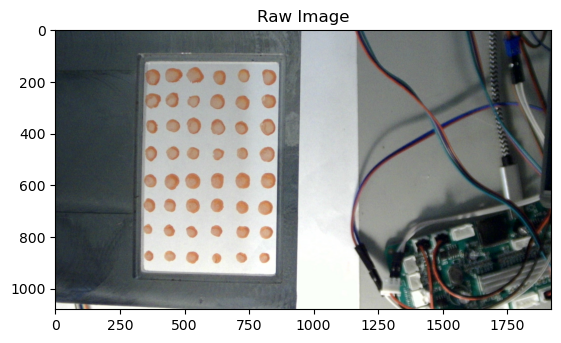

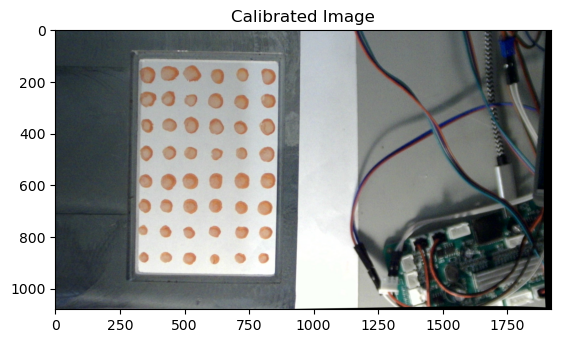

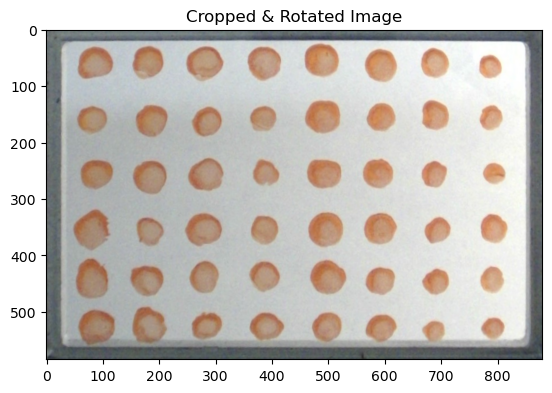

In [2]:
image = cv2.cvtColor(cv2.imread(f'{os.getcwd()}\\data\\validation_CsBiI.jpg'), cv2.COLOR_RGB2BGR)
K = pickle.load(open(f'{os.getcwd()}\\data\\camera_intrinsics.pkl', 'rb')) # load calibrated camera intrinsics

dst = cv2.undistort(image, K['mtx'], K['dist'], None, K['mtx']) # undistort image using camera instrinics
plt.imshow(image)
plt.title('Raw Image')
plt.show()
plt.imshow(dst)
plt.title('Calibrated Image')
plt.show()

#rotation angle in degree
dst_rot = ndimage.rotate(dst, 1)
result = cv2.rotate(dst_rot[115:995,305:890], cv2.ROTATE_90_COUNTERCLOCKWISE) # crop with tolerance for later cropping via harris corner detection & SAM
plt.imshow(result)
plt.title('Cropped & Rotated Image')
plt.show()

# Computer Vision Segmentation

Meta AI's [Segment Anything Model](https://github.com/facebookresearch/segment-anything?tab=readme-ov-file) is used to segment the pixels of each material.

To run the model, a checkpoint must be downloaded and its file path must be indicated below.

- Download the "vit_b" checkpoint [here](https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth)

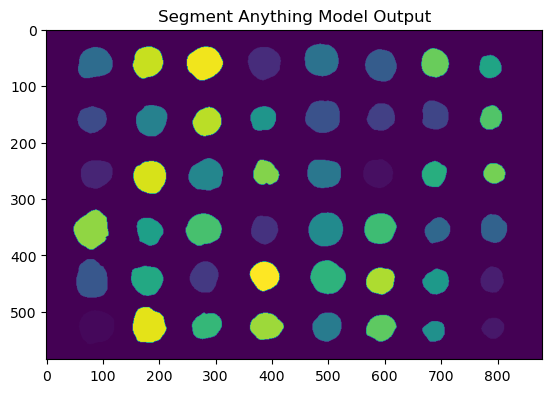

In [3]:
# checkpoint = f"{os.getcwd()}\\sam_checkpoints\\sam_vit_b_01ec64.pth"
checkpoint = '<FILE_PATH>'
model_type = "vit_b"
objects = robot_functions.generate_segments(result, checkpoint, model_type, min_size = 1e3, max_size=2e5)
plt.imshow(objects)
plt.title('Segment Anything Model Output')
plt.show()

# Pose Optimization

Perform optimization of robot contact poses using the computer vision segmentation output. 

- Set user-defined variables below about probe geometry and optimization procedure.

In [4]:
# ==== USER-DEFINED VARIABLES ==== #
max_angle = 45 # maximum angle achievable by the robot in the yaw-axis
px_to_mm = 0.117 # mm/pixel conversion
probe_stroke_mm = 4.5 # mm width of the probe
NUM_IMAGES = 1 # number of sets of optimal poses to generate
k_poses = 3 # number of optimal poses to generate per material
max_poses = 1000 # maximum number of poses to test
# ================================ #
probe_stroke_pixels = probe_stroke_mm / px_to_mm
print(f'Probe width mm: {probe_stroke_mm}\nProbe width pixels: {np.round(probe_stroke_pixels,2)}')

Probe width mm: 4.5
Probe width pixels: 38.46


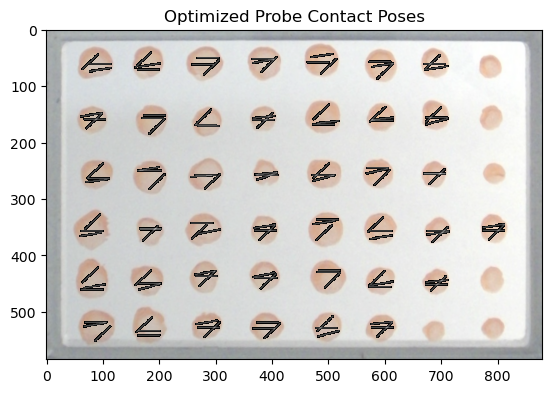

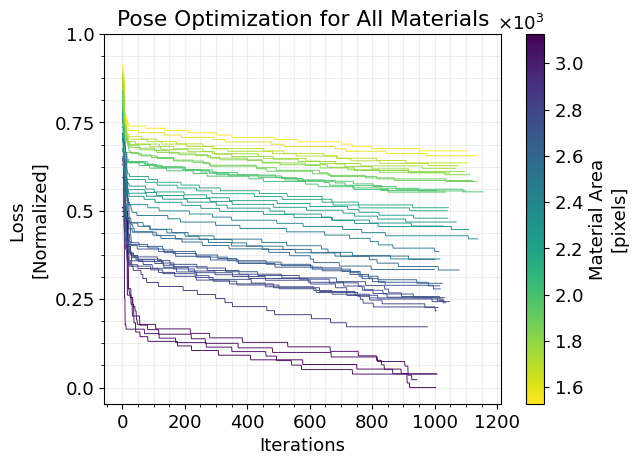

In [5]:
# run pose optimization using the reward_function()
target_poses = []
contact_pixels = []
rewards = []
total_pixels = []
for t in range(NUM_IMAGES): # get t number of unique sets of poses
    contact_pixels_int = []
    unique_idx = np.unique(objects)[1:]
    for n in range(len(unique_idx)):
        obj = np.copy(objects)
        obj[obj != unique_idx[n]] = 0 # select only the object with unique index, all else zero
        poses, pixel_poses, reward, total_pixel = robot_functions.reward_function(droplet=obj, poses=k_poses, max_poses=max_poses, max_angle=max_angle, probe_stroke_px=probe_stroke_pixels, verbose=False)
        if len(poses) > 0: # only run if droplet is sufficient size
            poses = np.array(poses)
            target_poses.append(poses)
            contact_pixels_int.append(pixel_poses)
            rewards.append(reward)
            total_pixels.append(total_pixel)
    contact_pixels.append(contact_pixels_int)
target_poses = np.array(target_poses).reshape(-1,3)

# plot poses on image
fig = plt.figure()
cmap = mpl.cm.binary_r
cmap.set_under(alpha=0)
pose_only_images = []
for t in range(NUM_IMAGES):
    object_contacts = np.copy(objects).astype(np.float64)
    pose_only = np.zeros(objects.shape).astype(np.float64)
    for i in range(len(contact_pixels[t])):
        for j in range(len(contact_pixels[t][i])):
            temp = np.zeros(objects.shape)
            temp[contact_pixels[t][i][j][0], contact_pixels[t][i][j][1]] = 1 # update frame pose. [x,y] format
            kernel = np.ones((2, 2), np.uint8)
            temp = cv2.dilate(temp, kernel)
            temp *= -1e4
            pose_only += temp
    pose_only_images.append(pose_only)
plt.imshow(result, alpha=0.6)
plt.imshow(pose_only_images[t]*-1, vmin=10,cmap=cmap)
plt.title('Optimized Probe Contact Poses')
plt.show()

# plot optimization results
mpl.rcParams.update({'font.size': 13})
cmap = mpl.cm.viridis
cmapr = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=np.min(total_pixels), vmax=np.max(total_pixels))
removal = 32 # remove outlier
reward_all = []
for n in range(len(rewards)):
    if n != removal:
        reward_all.append(np.max(rewards[n][1][:,1]))
fig, ax = plt.subplots()
for n in range(len(rewards)):
    if n != removal:
        reward_i = np.max(reward_all) - np.sort(rewards[n][1][:,1])
        ax.plot(reward_i, c=cmap(norm(total_pixels[n])), alpha=1, lw=0.65)
        ax.minorticks_on()
sm = mpl.cm.ScalarMappable(cmap=cmapr, norm=norm)
sm.set_array([])  # Dummy mappable array for the colorbar
cbar = plt.colorbar(sm, ax=ax, label='Material Area\n[pixels]')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
plt.grid(which='both', alpha=0.2)
plt.ylabel('Loss \n[Normalized]')
plt.xlabel('Iterations')
ytick_positions = np.linspace(0, 0.05, 5) 
ytick_labels = np.linspace(0, 1, 5) 
ax.set_yticks(ytick_positions)
ax.set_yticklabels(ytick_labels)
plt.title('Pose Optimization for All Materials');

# Path Planning Optimization

Perform travel distance minimization across generated path plans.

- Set user-defined variables below about the optimization procedure.

In [6]:
# ==== USER-DEFINED VARIABLES ==== #
max_angle = 45 # maximum angle achievable by the robot in the yaw-axis
noise_level = objects.shape[1]*0.02 # median noise level to test for stochastic path optimization
max_rounds = 1001 # maximum number of optimization rounds
# ================================ #

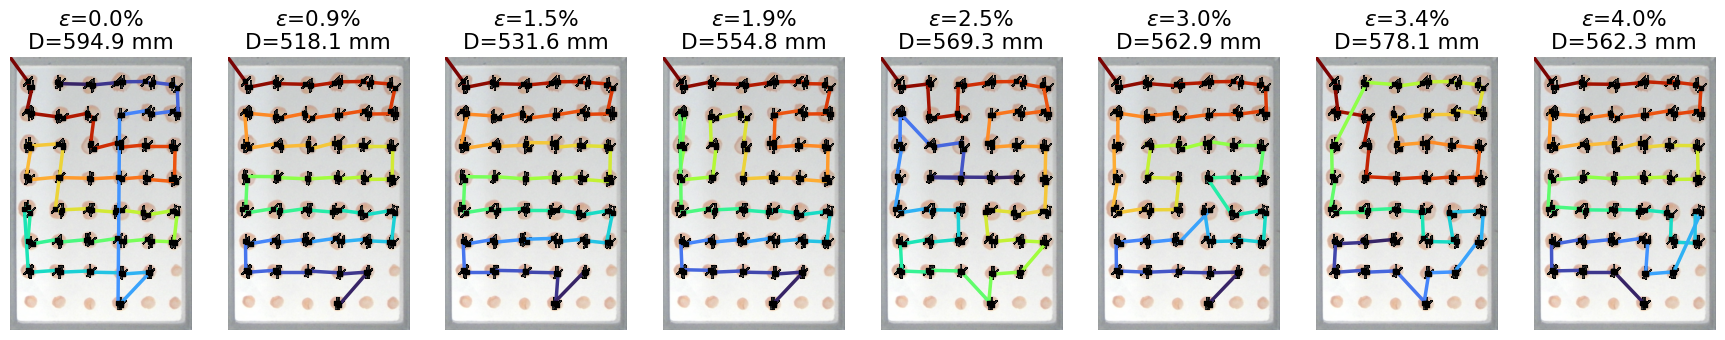

In [7]:
# run path plan optimization
plans0, distances0 = robot_functions.path_planning(target_poses[:,:2], optimization_rounds=1, noise_level=None) # show deterministic output with noise_leve=None
plans, distances = robot_functions.path_planning(target_poses[:,:2], optimization_rounds=max_rounds, noise_level=noise_level) # run full optimization of stochastic paths

# plot optimized path plans
cmap = mpl.cm.binary_r
cmap.set_under(alpha=0)
citer = mpl.cm.turbo_r
noise_levels = np.linspace(noise_level/2, noise_level*2, 7).astype(int)
o = 0 # select best plan
fig, axes = plt.subplots(1, len(plans)+1, figsize=(22, 15))
ax0 = axes[0]
pathx = plans0[0][0][:,1]
pathy = plans0[0][0][:,0]
dist_vals = np.linspace(0, 1, len(pathx))
ax0.imshow(result.transpose(1,0,2), alpha=0.6)
ax0.imshow((pose_only_images[t]*-1).transpose(1,0), vmin=10,cmap=cmap)
for i in range(len(pathx)):
    ax0.plot(pathy[i:i+2], pathx[i:i+2], color=citer(dist_vals[i]), lw=2.5, zorder=5)
ax0.scatter(target_poses[:,0], target_poses[:,1],c='k',s=10, marker='s',zorder=10)
ax0.set_title(r'$\varepsilon$'+f'=0.0%\nD={(distances0[0][0] * px_to_mm).round(1)} mm')
ax0.axis('off')
for n in range(len(plans)):
    sorted_idx = np.argsort(distances[n]) # sort from most optimal to least optimal
    pathx = plans[n][sorted_idx[o]][:,1]
    pathy = plans[n][sorted_idx[o]][:,0]
    dist_vals = np.linspace(0, 1, len(pathx))
    ax = axes[n+1]
    ax.imshow(result.transpose(1,0,2), alpha=0.6)
    ax.imshow((pose_only_images[t]*-1).transpose(1,0), vmin=10,cmap=cmap)
    for i in range(len(pathx)):
        ax.plot(pathy[i:i+2], pathx[i:i+2], color=citer(dist_vals[i]), lw=2.5, zorder=5)
    ax.scatter(target_poses[:,0], target_poses[:,1],c='k',s=10, marker='s',zorder=10)
    ax.set_title(r'$\varepsilon$'+f'={(noise_levels[n]/objects.shape[1]*100).round(1)}%\nD={(distances[n][sorted_idx[o]] * px_to_mm).round(1)} mm')
    ax.axis('off')
plt.show();

# Save Optimized Poses and Path

Perform a final round of calibrating the optimized poses in the image frame to the robot frame. Then, show the final set of optimal poses, ordered in the optimal path.

In [8]:
best_idx = 0 # 0.9% noise produces the best path plan in this seed
sorted_idx = np.argsort(distances[best_idx])
pathx = plans[best_idx][sorted_idx[0]][:,1]
pathy = plans[best_idx][sorted_idx[0]][:,0]

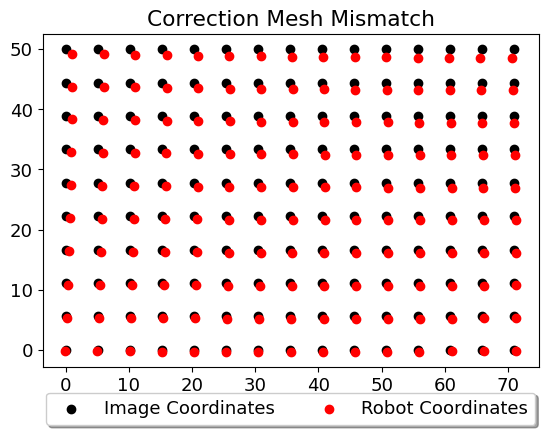

,x,y,theta
0,-0.04,-0.23,0.0
1,6.89,4.25,44.0
2,8.47,4.49,0.0
3,8.48,5.36,8.0
4,7.11,12.45,8.0
...,...,...,...
122,61.14,34.87,44.0
123,60.78,35.06,0.0
124,70.41,26.35,44.0
125,69.97,26.12,0.0


In [9]:
# load correction mesh to calibrate optimized poses in the image from to the robot frame.
correction_mesh = np.array(pd.read_csv(f'{os.getcwd()}\\data\\correction_mesh.csv')) # load correction mesh
rectified_corners_empirical = np.float32(np.array([[0., 0.], # load image-robot coordinate pairs for corners only
                                       [-1.5,52],
                                       [77.5,-5.], 
                                       [77.5,47.]]))

# save optimal path and poses, uncorrected
target_poses_origin = np.vstack([target_poses, [0,0,0]])
rotations_idx = []
for x in range(len(pathx)):
        condition = np.where((target_poses_origin[:,0]==pathy[x]) & (target_poses_origin[:,1]==pathx[x]))[0]
        rotations_idx.append(condition[0])
rotations_sorted = target_poses_origin[:,2][rotations_idx]
poses_matrix = np.array([pathx, pathy, rotations_sorted]).T
sorted_poses = pd.DataFrame(poses_matrix)

# correct the optimal poses using empirical corners and correction mesh
current_corners = np.float32(np.array([[0.,0.],
                          [0.,result.shape[0]],
                          [result.shape[1],0.],
                           [result.shape[1], result.shape[0]]]))
matrix = cv2.getPerspectiveTransform(current_corners, rectified_corners_empirical)
poses_rectified = cv2.perspectiveTransform(np.array([poses_matrix[:,:2]], dtype="float32"), matrix)
sorted_poses_rectified = np.hstack([poses_rectified[0].round(2), rotations_sorted.reshape(-1,1)])
sorted_poses_rectified_df = pd.DataFrame(sorted_poses_rectified)
xs = np.linspace(0,71, 15)
ys = np.linspace(0,50, 10)
Xs, Ys = np.meshgrid(xs,ys)
grid = np.array([Xs.reshape(-1), Ys.reshape(-1)]).T
# Create a polynomial regression model to apply correction
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression(fit_intercept=False))
])
# Fit the model
model.fit(correction_mesh[:,0:2], correction_mesh[:,2:4])
# Get general correction grid
grid_corrected = model.predict(grid)
plt.scatter(grid[:,0],grid[:,1], c='k',zorder=5, label='Image Coordinates')
plt.scatter(grid_corrected[:,0],grid_corrected[:,1],c='r',zorder=10, label='Robot Coordinates')
plt.title('Correction Mesh Mismatch')
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()
# apply correction model and display final poses
poses_corrected = model.predict(sorted_poses_rectified[:,:2])
poses_corrected_df = pd.DataFrame(np.hstack([poses_corrected.round(2), rotations_sorted.reshape(-1,1)]), columns=['x','y','theta'])
display(poses_corrected_df)